# Forest Fire Subset Definition

- Other approach
- Instead of focusing on all fires in an entire year, we focus on several firest that were covered well
- → Jueterbog / Luckenwalde
  - 2018/08/24: https://www.dw.com/en/forest-fires-near-berlin-could-burn-for-days/a-45203042
    - Article says "fires began on thursday", i.e. 2018/08/23
  - 2019
    - Fire in June ("einer der größten Brände der letzten Jahrzehnte") https://web.archive.org/web/20190622070809/https://www.rbb24.de/panorama/beitrag/2019/06/waldbrand-jueterbog-sonntag-lage-unter-kontrolle.html
    - Another fire in July https://web.archive.org/web/20190730000919/https://www.rbb24.de/panorama/beitrag/2019/07/loescharbeiten-jueterbog-truppenuebungsplatz-brandenburg.html

In [1]:
from datetime import date, timedelta
import os
from sentinel_helpers import search_osm, plot_downloaded_products
from sentinelsat import SentinelAPI
from pathlib import Path
from tqdm.notebook import tqdm

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))
api._tqdm = tqdm

out_dir = Path('resources/forest_fires')
out_dir.mkdir(exist_ok=True, parents=True)

## 2018
### Brandenburg

- Take the places from the DW article
  - `.head(n=1)` takes the first search result, they are ordered by how well they match our query
- We don't have info on the exact time of the location, article is written on 2018-08-24

In [2]:
import geopandas as gpd
import pandas as pd
from sentinel_helpers import geodataframe_on_map

In [3]:
frohnsdorf = search_osm('Frohnsdorf, Brandenburg').head(n=1)
klausdorf = search_osm('Klausdorf, Brandenburg').head(n=1)
tiefenbrunnen = search_osm('Tiefenbrunnen, Brandenburg').head(n=1)

In [4]:
evacuated_places = gpd.GeoDataFrame(pd.concat([frohnsdorf, klausdorf, tiefenbrunnen]))
geodataframe_on_map(evacuated_places)

In [5]:
evacuated_places.to_file(out_dir / 'evacuated_2018.json', driver='GeoJSON')

In [6]:
from shapely.geometry import box

In [7]:
article_date = date(2018, 8, 24)
pre_fire_2018 = article_date - timedelta(weeks=4)
post_fire_2018 = article_date + timedelta(weeks=4)

In [8]:
footprint_2018 = box(*evacuated_places.to_crs('epsg:25833').buffer(2500).to_crs('epsg:4326').unary_union.bounds)
results = api.query(footprint_2018.wkt,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(pre_fire_2018, post_fire_2018),
                    cloudcoverpercentage=(0, 30))

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:xlabel='beginposition'>

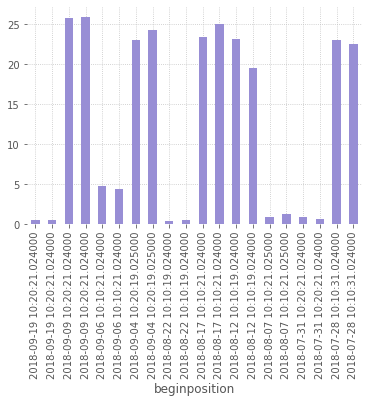

In [9]:
gdf = SentinelAPI.to_geodataframe(results)
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

- deduplicate the captured products
- avoid reprojecting, avoid merging

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

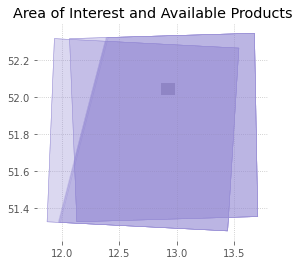

In [10]:
plot_downloaded_products(gdf, footprint_2018)

- we can take any product because the all easily contain the study area

In [11]:
gdf['tile'] = gdf['title'].apply(lambda t: t.split('_')[5])
gdf['tile'].unique()

array(['T33UUT', 'T32UQC'], dtype=object)

<AxesSubplot:xlabel='beginposition'>

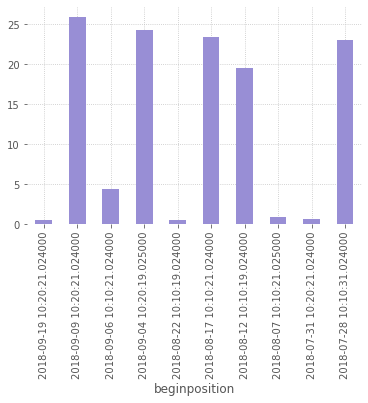

In [12]:
gdf = gdf[gdf['tile'] == 'T33UUT']
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

- from the plot we select the following timestamps:
  - criteria: low cloud coverage, close to before and after the fire
  - we don't know exactly how long it burned, so we take the last one as well

In [13]:
timestamps = [
    '2018-08-07 10:10:21.025000',
    '2018-08-22 10:10:19.024000',
    '2018-09-19 10:20:21.024000'
]
product_uuids_2018 = gdf[gdf['beginposition'].isin(timestamps)]['uuid'].values

In [14]:
out_dir.mkdir(exist_ok=True, parents=True)
downloaded, initialized, failed = api.download_all(product_uuids_2018, out_dir)

In [15]:
len(downloaded)

3

In [16]:
[(d.get('size'), d.get('path')) for d in downloaded.values()]

[(1092289485,
  'resources/forest_fires/S2B_MSIL2A_20180822T101019_N0208_R022_T33UUT_20180822T161243.zip'),
 (17931832,
  'resources/forest_fires/S2A_MSIL2A_20180919T102021_N0208_R065_T33UUT_20180919T132226.zip'),
 (16481848,
  'resources/forest_fires/S2A_MSIL2A_20180807T101021_N0208_R022_T33UUT_20180809T112302.zip')]

In [17]:
len(initialized)

0

In [18]:
len(failed)

0

- output paths:

In [19]:
list(map(lambda d: d.get('path'), downloaded.values()))

['resources/forest_fires/S2B_MSIL2A_20180822T101019_N0208_R022_T33UUT_20180822T161243.zip',
 'resources/forest_fires/S2A_MSIL2A_20180919T102021_N0208_R065_T33UUT_20180919T132226.zip',
 'resources/forest_fires/S2A_MSIL2A_20180807T101021_N0208_R022_T33UUT_20180809T112302.zip']

## 2019
### Jueterbog

- https://web.archive.org/web/20190622070809/https://www.rbb24.de/panorama/beitrag/2019/06/waldbrand-jueterbog-sonntag-lage-unter-kontrolle.html
- Article date: 2019-06-19
  - Article says: fire is put out, fire fighting again responsibility of communities
  - "have been at work for one week"

In [20]:
jueterbog = search_osm('Jüterbog, Brandenburg')
jueterbog = jueterbog[(jueterbog['type'] == 'administrative') & (jueterbog['osm_type'] == 'relation')]
jueterbog

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,257891092,relation,422436,"Jüterbog, Teltow-Fläming, Brandenburg, 14913, ...",16,boundary,administrative,0.685236,https://nominatim.openstreetmap.org/ui/mapicon...,"POLYGON ((12.95605 52.03939, 12.96134 52.03944..."


In [21]:
geodataframe_on_map(jueterbog)

- we increase the geometry size by 2.5km in each direction

In [22]:
jueterbog.to_file(out_dir / 'jueterbog_2019.json', driver='GeoJSON')

In [23]:
import geopandas as gpd

buffered = jueterbog.to_crs('epsg:25833').buffer(2500).to_crs('epsg:4326')
geodataframe_on_map(buffered)

- now we search for products in the relevant time frame

In [24]:
article_date = date(2019, 6, 16)
pre_fire_2019 = article_date - timedelta(weeks=4)
post_fire_2019 = article_date + timedelta(weeks=4)

In [25]:
footprint_2019 = buffered.iloc[0].convex_hull
results = api.query(footprint_2019.wkt,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(pre_fire_2019, post_fire_2019),
                    cloudcoverpercentage=(0, 30))

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:xlabel='beginposition'>

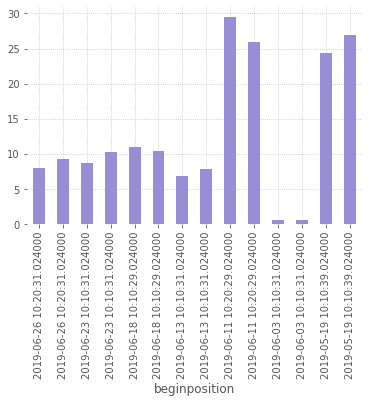

In [26]:
gdf = SentinelAPI.to_geodataframe(results)
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

- how well do the results cover our study area?

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

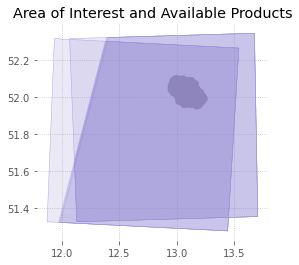

In [27]:
plot_downloaded_products(gdf, buffered)

- again, well!

<AxesSubplot:xlabel='beginposition'>

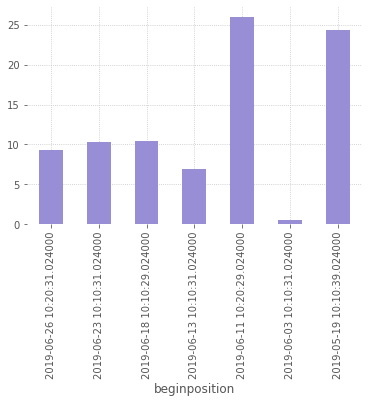

In [28]:
gdf['tile'] = gdf['title'].apply(lambda t: t.split('_')[5])
gdf = gdf[gdf['tile'] == 'T33UUT']
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

In [29]:
timestamps = [
    '2019-06-03 10:10:31.024000', # before the fire, almost no clouds\n",
    '2019-06-13 10:10:31.024000', # during the fire?\n",
    '2019-06-26 10:20:31.024000', # after the fire, within cloud coverage < 30%\n",
]
product_uuids_2019 = gdf[gdf['beginposition'].isin(timestamps)]['uuid'].values

In [30]:
downloaded, initialized, failed = api.download_all(product_uuids_2019, out_dir)

In [31]:
len(downloaded)

3

In [32]:
len(initialized)

0

In [33]:
len(failed)

0

In [34]:
failed

{}

- originally downloaded: 0, initialized: 1, failed: 2
- failed product with uuid `1e9358eb-2c1e-45a5-aabd-ee7b193eda0e` has status code `202 Accepted`, so not actually failed?
- all products could be downloaded within 5 hours


- output paths

In [35]:
list(downloaded.values())

[{'id': '42633406-e729-4d38-94df-942813cac1c0',
  'title': 'S2A_MSIL2A_20190613T101031_N0212_R022_T33UUT_20190614T125329',
  'size': 17677880,
  'md5': '89684d0e302cd35f4eff66e6e89f29c9',
  'date': datetime.datetime(2019, 6, 13, 10, 10, 31, 24000),
  'footprint': 'POLYGON((12.109949135874256 51.62754367459543,12.12855260381174 51.67223353291847,12.189749670211857 51.8181446227169,12.251335944032553 51.96394652824928,12.313165570575627 52.109686926175314,12.374979421078276 52.25542506753664,12.402567238605169 52.3200953024738,13.675924550313963 52.34305438492137,13.704578464673325 51.35607984388353,12.12921085152078 51.3280532483229,12.109949135874256 51.62754367459543))',
  'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('42633406-e729-4d38-94df-942813cac1c0')/$value",
  'Online': True,
  'Creation Date': datetime.datetime(2019, 6, 15, 0, 11, 53, 498000),
  'Ingestion Date': datetime.datetime(2019, 6, 14, 22, 44, 51, 876000),
  'path': 'resources/forest_fires/S2A_MSIL2A_2

In [36]:
list(map(lambda d: d.get('path'), downloaded.values()))

['resources/forest_fires/S2A_MSIL2A_20190613T101031_N0212_R022_T33UUT_20190614T125329.zip',
 'resources/forest_fires/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUT_20190603T114652.zip',
 'resources/forest_fires/S2A_MSIL2A_20190626T102031_N0212_R065_T33UUT_20190626T125319.zip']

### Lübtheen

- https://earth.esa.int/eogateway/news/german-wildfire
- flyover during active fire at 2019-06-30

In [37]:
luebtheen = search_osm('Lübtheen, Germany')
luebtheen = luebtheen[(luebtheen['osm_type'] == 'relation') & (luebtheen['type'] == 'administrative')]
luebtheen

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,258938877,relation,1451563,"Lübtheen, Ludwigslust-Parchim, Mecklenburg-Vor...",16,boundary,administrative,0.573723,https://nominatim.openstreetmap.org/ui/mapicon...,"POLYGON ((10.98272 53.32736, 10.98394 53.32676..."


In [38]:
geodataframe_on_map(luebtheen)

In [39]:
luebtheen.to_file(out_dir / 'luebtheen_2019.json', driver='GeoJSON')

In [40]:
luebtheen_date = date(2019, 6, 30)
luebtheen_before = luebtheen_date - timedelta(weeks=4)
luebtheen_after = luebtheen_date + timedelta(weeks=4)
luebtheen_footprint = luebtheen['geometry'].iloc[0].convex_hull

In [41]:
results = api.query(luebtheen_footprint.wkt,
                    platformname='Sentinel-2',
                    processinglevel='Level-2A',
                    date=(luebtheen_before, luebtheen_after),
                    cloudcoverpercentage=(0, 50))
gdf = SentinelAPI.to_geodataframe(results)
gdf.head()

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,...,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
6e5c5f7c-457d-4ffa-a2a7-7e9d840d8eaf,S2A_MSIL2A_20190726T102031_N0213_R065_T32UPD_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-07-26T10:20:31.024Z, Instrument: MS...",false,2019-07-26 10:20:31.024,2019-07-26 10:20:31.024,2019-07-26 17:09:03.510,21369,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.08 GB,S2A_MSIL2A_20190726T102031_N0213_R065_T32UPD_2...,S2A_OPER_MSI_L1C_TL_SGS__20190726T121947_A0213...,S2A_MSIL2A_20190726T102031_N0213_R065_T32UPD_2...,6e5c5f7c-457d-4ffa-a2a7-7e9d840d8eaf,"MULTIPOLYGON (((12.07168 52.22257, 12.14177 53..."
b0715f32-b213-420c-a2f4-34dca13072b5,S2A_MSIL2A_20190726T102031_N0213_R065_T32UPE_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-07-26T10:20:31.024Z, Instrument: MS...",false,2019-07-26 10:20:31.024,2019-07-26 10:20:31.024,2019-07-26 16:59:35.134,21369,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.05 GB,S2A_MSIL2A_20190726T102031_N0213_R065_T32UPE_2...,S2A_OPER_MSI_L1C_TL_SGS__20190726T121947_A0213...,S2A_MSIL2A_20190726T102031_N0213_R065_T32UPE_2...,b0715f32-b213-420c-a2f4-34dca13072b5,"MULTIPOLYGON (((12.13532 53.11988, 12.20926 54..."
3dc30957-8b84-4238-a6b8-d499575c92d9,S2B_MSIL2A_20190724T103029_N0213_R108_T32UPD_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-07-24T10:30:29.024Z, Instrument: MS...",false,2019-07-24 10:30:29.024,2019-07-24 10:30:29.024,2019-07-24 16:13:05.070,12432,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.00 GB,S2B_MSIL2A_20190724T103029_N0213_R108_T32UPD_2...,S2B_OPER_MSI_L1C_TL_SGS__20190724T122822_A0124...,S2B_MSIL2A_20190724T103029_N0213_R108_T32UPD_2...,3dc30957-8b84-4238-a6b8-d499575c92d9,"MULTIPOLYGON (((11.82221 52.22736, 11.84880 52..."
1eef4c24-7414-4065-aeab-fa4db566f9f2,S2B_MSIL2A_20190724T103029_N0213_R108_T32UPE_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-07-24T10:30:29.024Z, Instrument: MS...",false,2019-07-24 10:30:29.024,2019-07-24 10:30:29.024,2019-07-24 16:11:09.233,12432,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.03 GB,S2B_MSIL2A_20190724T103029_N0213_R108_T32UPE_2...,S2B_OPER_MSI_L1C_TL_SGS__20190724T122822_A0124...,S2B_MSIL2A_20190724T103029_N0213_R108_T32UPE_2...,1eef4c24-7414-4065-aeab-fa4db566f9f2,"MULTIPOLYGON (((12.13532 53.11988, 12.20926 54..."
3f59c341-0918-45d2-94d4-a31893e7b167,S2B_MSIL2A_20190721T102029_N0213_R065_T32UPD_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2019-07-21T10:20:29.024Z, Instrument: MS...",false,2019-07-21 10:20:29.024,2019-07-21 10:20:29.024,2019-07-21 20:17:35.045,12389,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.08 GB,S2B_MSIL2A_20190721T102029_N0213_R065_T32UPD_2...,S2B_OPER_MSI_L1C_TL_MPS__20190721T123558_A0123...,S2B_MSIL2A_20190721T102029_N0213_R065_T32UPD_2...,3f59c341-0918-45d2-94d4-a31893e7b167,"MULTIPOLYGON (((12.07168 52.22257, 12.14177 53..."


<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

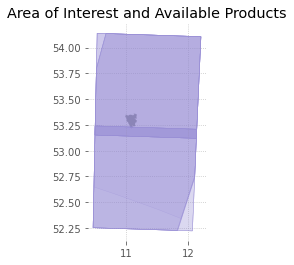

In [42]:
plot_downloaded_products(gdf, luebtheen)

<AxesSubplot:xlabel='beginposition'>

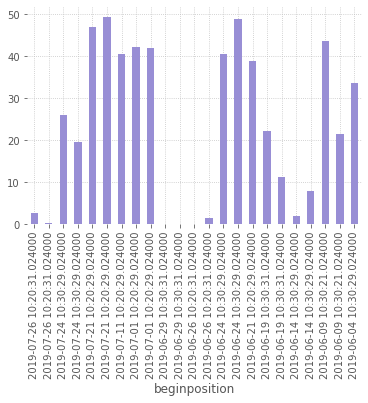

In [43]:
gdf.set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

In [44]:
gdf['tile'] = gdf['title'].apply(lambda t: t.split('_')[5])
gdf['tile'].unique()

array(['T32UPD', 'T32UPE'], dtype=object)

- we want products that cover the entire area (avoid merging)
- we also want products that have a good cloud coverage
- plus we want the product that was used to generate the other image

<AxesSubplot:xlabel='beginposition'>

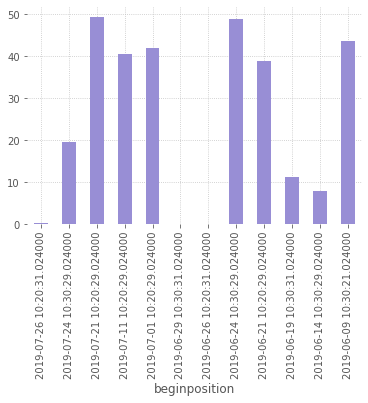

In [45]:
gdf[gdf['tile'] == 'T32UPE'].set_index('beginposition')['cloudcoverpercentage'].plot(kind='bar')

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

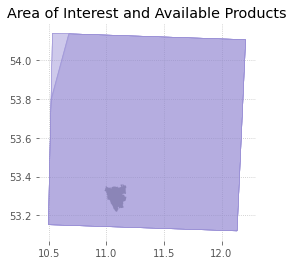

In [46]:
plot_downloaded_products(gdf[gdf['tile'] == 'T32UPE'], luebtheen)

In [47]:
gdf = gdf[gdf['tile'] == 'T32UPE']
timestamps = [
    '2019-06-29 10:30:31.024000', # before the fire, almost no clouds
    '2019-07-01 10:20:29.024000', # during the fire; the esa picture is generated from this
    '2019-07-26 10:20:31.024000', # after the fire, within cloud coverage < 50%
]
product_uuids_luebtheen_2019 = gdf[gdf['beginposition'].isin(timestamps)]['uuid'].values

In [48]:
downloaded, initialized, failed = api.download_all(product_uuids_luebtheen_2019, out_dir)
len(downloaded), len(initialized), len(failed)

(3, 0, 0)

- "unexpected response 200 from Scihub"

In [49]:
list(map(lambda d: d.get('path'), downloaded.values()))

['resources/forest_fires/S2B_MSIL2A_20190701T102029_N0212_R065_T32UPE_20190701T134657.zip',
 'resources/forest_fires/S2A_MSIL2A_20190629T103031_N0212_R108_T32UPE_20190629T135351.zip',
 'resources/forest_fires/S2A_MSIL2A_20190726T102031_N0213_R065_T32UPE_20190726T125507.zip']

- copy these values into "02 Spectral Indices.ipynb"

In [50]:
downloaded

{'6e9e2e63-aa4c-4cd4-aa05-98e41208b640': {'id': '6e9e2e63-aa4c-4cd4-aa05-98e41208b640',
  'title': 'S2B_MSIL2A_20190701T102029_N0212_R065_T32UPE_20190701T134657',
  'size': 1134597847,
  'md5': '382a7488a5c361dbdb88b7808c22b318',
  'date': datetime.datetime(2019, 7, 1, 10, 20, 29, 24000),
  'footprint': 'POLYGON((10.518354904070659 53.7935210188657,10.541655284299154 53.84531320490865,10.607690679302356 53.990633600476926,10.673849545808116 54.135553222437636,12.209260084873382 54.10530483528773,12.135320369204086 53.119880621881606,10.495379581512257 53.15178549855093,10.518354904070659 53.7935210188657))',
  'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('6e9e2e63-aa4c-4cd4-aa05-98e41208b640')/$value",
  'Online': True,
  'Creation Date': datetime.datetime(2019, 7, 1, 20, 27, 9, 152000),
  'Ingestion Date': datetime.datetime(2019, 7, 1, 20, 25, 48, 545000),
  'path': 'resources/forest_fires/S2B_MSIL2A_20190701T102029_N0212_R065_T32UPE_20190701T134657.zip',
  'downloade